# Making inference with pretrained UNet and B-UNet models

Define functions and set up environment

In [1]:
import torch
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import ants
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchviz import make_dot
from colossalai.utils import load_checkpoint
from colossalai.initialize import launch,initialize
import colossalai
from colossalai.trainer import Trainer, hooks
import h5py as h5
from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader
import torchio as tio

from ipywidgets import interact, fixed
from IPython.display import clear_output

In [48]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_image(image_z, image):
    img = image[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

def display_multiplanar(image):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
    im1 = ax1.imshow(image[image.shape[0]//2,:,:], cmap=plt.cm.Greys_r)
    ax1.axis('off')
    im2 = ax2.imshow(image[:,image.shape[1]//2,:], cmap=plt.cm.Greys_r)
    ax2.axis('off')
    im3 = ax3.imshow(image[:,:,image.shape[2]//2], cmap=plt.cm.Greys_r)
    ax3.axis('off')

def load_model(model_path:str):
    model = torch.load(model_path)
    model.train()
    return model

def load_image(mode :str = 'h5', 
               paths = ['/home/viscent/hdd/dhcp/dhcp_lores/preprocessed_h5/sub-CC00582XX14.h5'],
               dataset = 'dhcp',
               data_dir = '/home/viscent/hdd/dhcp/dhcp_lores/',):
    if mode == 'h5':
        with h5.File(paths[0],'r') as f:
            image = f['image_t1'][...].astype(np.float32)
            target = f['gt_t1'][...].astype(np.float32)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'sitk':
        image = sitk.ReadImage(paths[0])
        target = sitk.ReadImage(paths[1])
        image = sitk.GetArrayFromImage(image)
        target = sitk.GetArrayFromImage(target)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'npy':
        image = np.load(paths[0])
        target = np.load(paths[1])
        image_tensor = torch.from_numpy(image).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'dataloader':
        if dataset == 'dhcp':
            dataloaders, val_loader = get_synth_dhcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        elif dataset == 'hcp':
            dataloaders, val_loader = get_synth_hcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        image_tensor, target_tensor = next(iter(val_loader))
        image_tensor = image_tensor.cuda()
        target_tensor = target_tensor.cuda()
        return image_tensor,target_tensor

def plot_latent(model):
    encoder_weights = next(model.encoders[-1].parameters())
    encoder_weights = encoder_weights.cpu().detach().numpy()
    encoder_weights= np.expand_dims(encoder_weights,axis=1)
    encoder_weights = np.repeat(encoder_weights, 128, axis=1)
    if hasattr(model, 'enc_mu'):
        fig,(ax1,ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(encoder_weights)
        ax1.set_title("encoder weights")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im1, cax=cax, orientation="vertical")

        latent_weights = next(model.mu.parameters())
        latent_weights = latent_weights.cpu().detach().numpy()
        latent_weights = np.repeat(latent_weights, 128, axis=1)

        im2 = ax2.imshow(encoder_weights)
        ax2.set_title("latent weights")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im2, cax=cax, orientation="vertical")
        fig.show()
    else:
        fig = plt.imshow(encoder_weights)
        plt.title("encoder weights")
        plt.colorbar()
        plt.show()
    # plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

def infer(model,image_tensor):
    output_tensor = model(image_tensor)
    return output_tensor

def get_metrics(output_tensor,target_tensor, model, mu_q = None, logvar_q = None):
    im = target_tensor
    im_hat = output_tensor
    mse = torch.nn.MSELoss()(im, im_hat)
    mse.backward()
    print('mse:', mse.cpu().detach().numpy())
    if hasattr(model, 'enc_mu'):
        # mu_p, logvar_p = model.enc_mu,model.enc_logvar
        # # kl = (0.5 * ((torch.ones_like(logvar_p)-torch.ones_like(logvar_p)) + (mu_p-mu_q)**2 / torch.ones_like(logvar_p).exp() - 1 + (torch.ones_like(logvar_p)).exp() / (torch.ones_like(logvar_p)).exp() )).sum()
        # # kl = (0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q)**2 / logvar_q.exp() - 1 + logvar_p.exp() / logvar_q.exp())).mean()
        # kl = 0.5 * (logvar_p.exp() + mu_p**2 - 1 - logvar_p).sum()
        # # kl = 0.5 * ((logvar_q-logvar_p) - 3 + (mu_p - mu_q) / logvar_q.exp() * (mu_p-mu_q) + torch.trace)
        # # kl = torch.sum(kl)

        ###### kl divergence with covariance ######
        mu_p = model.enc_mu.flatten()
        logvar_p = model.enc_logvar.flatten()

        cov_p = torch.exp(logvar_p)
        cov_p[cov_p.isnan()] = cov_p.mean()
        cov_p[cov_p == 0] = cov_p.mean()
        cov_p = cov_p.diag()
        cov_q = torch.exp(logvar_q)
        cov_q[cov_q.isnan()] = cov_q.mean()
        cov_q[cov_q == 0] = cov_q.mean()
        cov_q = cov_q.diag()
        k = mu_p.shape[0]

        tmp = ((mu_p-mu_q)**2 / torch.exp(logvar_q))
        tmp[tmp.isnan()] = tmp.median()
        tmp[tmp.isinf()] = tmp.median()
        tmp = tmp.sum()
        kl = 0.5 *( logvar_q.sum() - logvar_p.sum() - k + tmp + (torch.exp(logvar_p-logvar_q).sum()))
        kl
        ###########################################


        FE_simple = mse + 0.00025 * kl
        print('kl:', kl.cpu().detach().numpy())
        print('Free energy:', FE_simple.cpu().detach().numpy())

def plot_output(image_tensor,output_tensor,target_tensor):
    image_tensor = image_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    output_tensor = output_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    target_tensor = target_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    im1 = ax1.imshow(image_tensor[image_tensor.shape[0]//2,:,:],cmap='gray')
    ax1.set_title("image")


    im2 = ax2.imshow(output_tensor[output_tensor.shape[0]//2,:,:],cmap='gray')
    ax2.set_title("output")
    
    
    im3 = ax3.imshow(target_tensor[target_tensor.shape[0]//2,:,:],cmap='gray')
    ax3.set_title("target")
    fig.show()
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def registration_sitk(fixed_image, moving_image):
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)


    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    return moving_resampled

def resample(image):
    target_shape = (108, 145, 145)
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    resample_transform = tio.Resample(target=spacing)
    resize_transform = tio.Resize(target_shape=target_shape)
    transform  = tio.Compose([resample_transform,resize_transform])
    return transform(image)

def downSample(image):
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    spacing *= 5
    target_shape = (108, 145, 145)
    factor = spacing[2] / spacing[0]
    resize_transform = tio.Resize(target_shape=target_shape)
    resample_transform = tio.Resample(target=spacing)
    blur_transform = tio.RandomBlur(3)
    transform  = tio.Compose([resample_transform,resize_transform,blur_transform])
    return transform(image)


def registration_ants(fixed_image, moving_image):
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    fixed_ants = ants.from_numpy(fixed_array)
    moving_ants = ants.from_numpy(moving_array)
    ret = ants.registration(fixed_ants, moving_ants,verbose=True)
    image = ret['warpedmovout'].numpy()
    image = sitk.GetImageFromArray(image)
    image.CopyInformation(fixed_image)
    return image

In [3]:
model_vae_dhcp = load_model('/media/hdd/viscent/create-models/20220706/vae_dhcp/160.pth')
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220706/vae_hcp/91.pth')
model_unet_dhcp = load_model('/media/hdd/viscent/create-models/20220607/unet_dhcp/299.pth')
model_unet_hcp = load_model('/media/hdd/viscent/create-models/20220607/unet_hcp/299.pth')

mu_vae_dhcp = model_vae_dhcp.enc_mu[0].flatten()
logvar_vae_dhcp = model_vae_dhcp.enc_logvar[0].flatten()
mu_vae_hcp = model_vae_hcp.enc_mu[0].flatten()
logvar_vae_hcp = model_vae_hcp.enc_logvar[0].flatten()

In [19]:
image_paul[...,4]

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fc9c31ec360> >

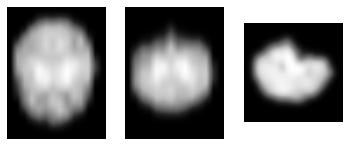

In [23]:
display_multiplanar(image_tensor[0,0].detach().cpu().numpy())

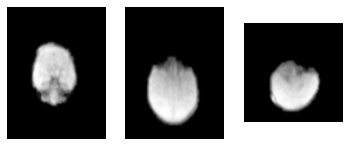

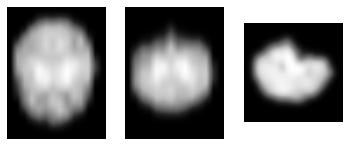

In [53]:
image_paul = sitk.ReadImage('/media/hdd/viscent/SR-UNet/inference/HF00051/HF00051_concatenated_TIs_64mT_brain.nii.gz')
image_paul = resample(image_paul)
image_paul = registration_sitk(image_paul,image_paul)
array_paul = sitk.GetArrayFromImage(image_paul)
display_multiplanar(array_paul)
display_multiplanar(image_tensor[0,0].detach().cpu().numpy())

In [30]:
image_tensor = torch.from_numpy(array_paul).float().unsqueeze(0).unsqueeze(0).cuda()

In [ ]:
# optim_vae_dhcp = torch.optim.Adam(
#     model_vae_dhcp.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.99)
# )
# optim_vae_hcp = torch.optim.Adam(
#     model_vae_hcp.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.99)
# )

# criteria = nn.MSELoss()

## Results on dHCP

In [37]:
image_tensor,target_tensor = load_image()
image_tensor_dHCP = image_tensor.clone()
target_tensor_dHCP = target_tensor.clone()

In [ ]:
sitk_image_dHCP = sitk.GetImageFromArray((image_tensor_dHCP.numpy()[0,0])*4096)
sitk.WriteImage(sitk_image_dHCP,'/media/hdd/viscent/SR-UNet/inference/image_dHCP.nii.gz')

In [92]:
mu_q = mu_vae_dhcp
mu_p = model_vae_dhcp.enc_mu
logvar_q = logvar_vae_dhcp
logvar_p = model_vae_dhcp.enc_logvar

In [ ]:
kl = (0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q)**2 / logvar_q.exp() - 1 + logvar_p.exp() / logvar_q.exp()))

In [ ]:
kl[kl.isnan()]=0
kl[kl.isinf()]=0

### VAE-dHCP

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x124416 and 256x1)

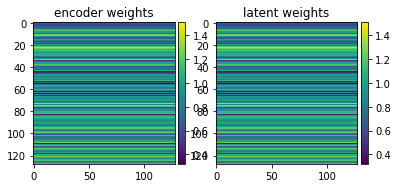

In [54]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

In [65]:
mu_p = model_vae_hcp.enc_mu.flatten()
logvar_p = model_vae_hcp.enc_logvar.flatten()
mu_q = mu_vae_hcp
logvar_q = logvar_vae_hcp

cov_p = torch.exp(logvar_p)
cov_p[cov_p.isnan()] = 1
cov_p[cov_p == 0] = 1
cov_p = cov_p.diag()
cov_q = torch.exp(logvar_q)
cov_q[cov_q.isnan()] = 1
cov_q[cov_q == 0] = 1
cov_q = cov_q.diag()

cov_q_inv = cov_q.inverse().diag()
cov_p_inv = cov_p.inverse().diag()
cov_q_inv[cov_q_inv.isnan()] = 1
cov_q_inv[cov_q_inv.isinf()] = 1
cov_q_inv[cov_q_inv == 0] = 1
cov_p_inv[cov_p_inv.isnan()] = 1
cov_p_inv[cov_p_inv.isinf()] = 1
cov_p_inv[cov_p_inv == 0] = 1
cov_q_inv = cov_q_inv.diag()
cov_p_inv = cov_p_inv.diag()

k = mu_p.shape[0]

In [74]:
kl = 0.5 *( logvar_q.sum() - logvar_p.sum() - k + (mu_p-mu_q).unsqueeze(0).matmul(cov_q_inv).matmul((mu_p-mu_q).unsqueeze(1)).squeeze(0).squeeze(0) + torch.trace(cov_q_inv.matmul(cov_p)))

In [90]:
np.seterr(all='raise') # raise error on overflow
tmp = ((mu_p-mu_q)**2 / torch.exp(logvar_q))
tmp[tmp.isnan()] = tmp.median()
tmp[tmp.isinf()] = tmp.median()
tmp = tmp.sum()
kl = 0.5 *( logvar_q.sum() - logvar_p.sum() - k + tmp + (torch.exp(logvar_p-logvar_q).sum()))
kl

tensor(3.6903e+32, device='cuda:0')

In [73]:
tmp = ((mu_p-mu_q).unsqueeze(0).matmul(cov_q_inv).T.squeeze(1) * (mu_p-mu_q))

print(tmp.sum())
print(logvar_q.sum() - logvar_p.sum() - k)
print(torch.trace(torch.inverse(cov_q).matmul(cov_p)))

tensor(7.3812e+32, device='cuda:0')
tensor(-832.6514, device='cuda:0')
tensor(nan, device='cuda:0')


### VAE-HCP

/tmp/ipykernel_3369953/1877682359.py:87: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



mse: 0.18352313
kl: 3.8181574e+33
Free energy: 9.545394e+29


/tmp/ipykernel_3369953/1877682359.py:155: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



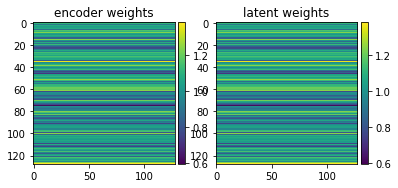

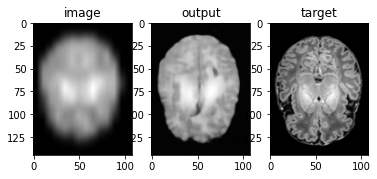

In [97]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-dHCP

In [ ]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

In [ ]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

## Results on HCP

In [98]:
image_tensor,target_tensor = load_image(mode='h5',paths=['/media/hdd/HCP_1200/preprocessed_h5/100206.h5'])
image_tensor_HCP = image_tensor.clone()
target_tensor_HCP = target_tensor.clone()

### VAE-dHCP

/tmp/ipykernel_3369953/1877682359.py:87: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



mse: 0.11194663
kl: 1.1433957e+29
Free energy: 2.8584895e+25


/tmp/ipykernel_3369953/1877682359.py:155: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



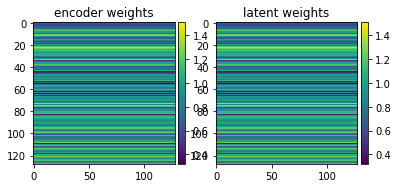

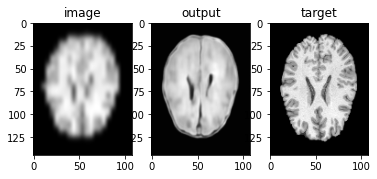

In [99]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### VAE-HCP

/tmp/ipykernel_3369953/1877682359.py:87: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



mse: 0.03730401
kl: 3.690263e+32
Free energy: 9.225658e+28


/tmp/ipykernel_3369953/1877682359.py:155: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



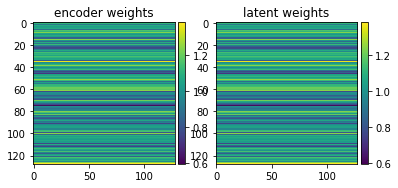

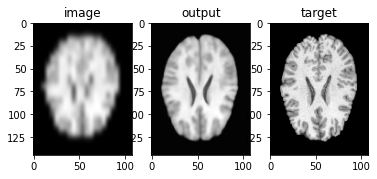

In [100]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-dHCP

In [ ]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

In [ ]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

## Cross-domain Evaluation

In [ ]:
# fixed_image = sitk.ReadImage('/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/001B/001B_mediumResShortTI.nii', sitk.sitkFloat32)
# moving_image = sitk.DICOMOrient(moving_image,'RAI')
# # Undo normalization

# temp_array = sitk.GetArrayFromImage(fixed_image)
# temp_array *= sitk.GetArrayFromImage(moving_image).max()
# temp_fixed = sitk.GetImageFromArray(temp_array)
# temp_fixed.CopyInformation(fixed_image)
# fixed_image = temp_fixed

# # fixed_image = downSample(fixed_image)
# moving_image = resample(moving_image)
# moving_ants = ants.from_numpy(sitk.GetArrayFromImage(moving_image))
# fixed_ants = ants.from_numpy(sitk.GetArrayFromImage(fixed_image))
# ret = ants.registration(fixed=fixed_ants, moving=moving_ants,verbose=True)
# target_tensor = torch.from_numpy(sitk.GetArrayFromImage(moving_image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(moving_image)
# image_tensor = torch.from_numpy(sitk.GetArrayFromImage(moving_image)).unsqueeze(0).unsqueeze(0).cuda()

In [ ]:
# moving_image.GetSpacing()

In [ ]:
fixed_image = sitk.ReadImage('/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/media/hdd/ds001894/sub-001/ses-T1/anat/sub-001_ses-T1_T1w.nii.gz', sitk.sitkFloat32)
moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/reg.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/T1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.DICOMOrient(moving_image,'RAI')

# Undo normalization

temp_array = sitk.GetArrayFromImage(fixed_image)
temp_array = (temp_array - temp_array.min()) / (temp_array.max() - temp_array.min()) * sitk.GetArrayFromImage(moving_image).max()
temp_fixed = sitk.GetImageFromArray(temp_array)
temp_fixed.CopyInformation(fixed_image)
fixed_image = temp_fixed

moving_image = resample(moving_image)

image = registration_ants(fixed_image,moving_image)
image = resample(image)
target_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(image)
image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).unsqueeze(0).unsqueeze(0).cuda()
# target_tensor = torch.clone(image_tensor).cuda()


In [ ]:
image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/reg.nii.gz', sitk.sitkFloat32)
image = downSample(image)
target_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(image)
image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).unsqueeze(0).unsqueeze(0).cuda()
# target_tensor = torch.clone(image_tensor).cuda()

In [ ]:
interact(
    display_image,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    image=fixed(downSample(fixed_image)),
);

In [ ]:
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)